# Evaluation

Now that we have a finetuned Model, let's see if we can get a better performance regarding the similarity between the captions.

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# import libraries

import os
import torch
import numpy as np
import gensim.downloader


from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

In [44]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' already exists.
Folder 'images' already exists.


To get the finetuned model in this notebook the easiest way ist to get the training weights by cloning this github repo itself.

In [6]:
!git clone https://github.com/raschnick/ml2_project_x.git

Cloning into 'ml2_project_x'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 62 (delta 22), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (62/62), 27.62 MiB | 9.62 MiB/s, done.


Now we can create the Model Pipeline with the weights. We take the model with the 50 training epochs here, since it performed the best in the comparison between the 3 training attempts. Which isn't exactly a surprise to be fair.

In [7]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe.unet.load_attn_procs('./ml2_project_x/model_weights/pytorch_lora_weights_50_epochs.bin')
pipe.to('cuda')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

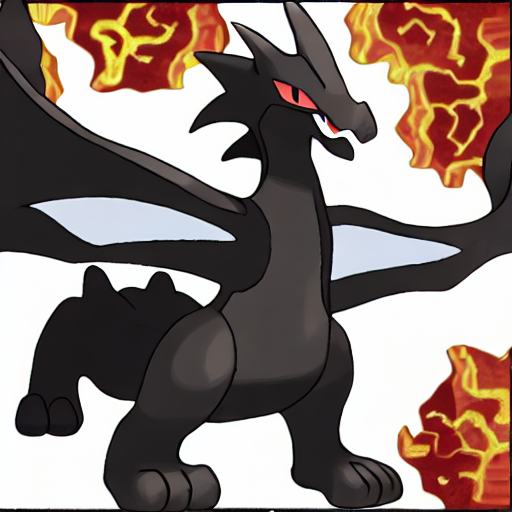

In [ ]:
image = pipe(prompt='a black dragon with fire').images[0]
image.save('images/test_image.png')
image.show()

This looks very cool, but now let's see how it performs if we compare multiple images via the pipeline. For this we can use the method that we wrote before, including the other helper functions and the google news word embedding:

In [13]:
# Set up BLIP model

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

# Download Google News Word Embedding. If it's downloaded already it won't do it again!

embedding_path = 'embeddings/word2vec-google-news-300.bin'
embedding_name = 'word2vec-google-news-300'

if os.path.exists(embedding_path):
    print("Word Embedding has been downloaded already.")
else:
  google_news_embedding = gensim.downloader.load(embedding_name)
  google_news_embedding.save(embedding_path)

google_news_word_embedding = gensim.models.KeyedVectors.load(embedding_path)


def get_mean_vector(sentence, word_embedding):
  tokens = sentence.split()
  embedding = [word_embedding[word] for word in tokens if word in word_embedding]

  if len(embedding) > 0:
    return np.mean(embedding, axis=0)
  else:
    return None


def calculate_mv_similarity(sentence_1_mv, sentence_2_mv):
  if sentence_1_mv is not None and sentence_2_mv is not None:
    similarity = 1 - cosine(sentence_1_mv, sentence_2_mv)
    return similarity
  else:
    return None


def run_pipeline_no_print(initial_caption, word_embedding):
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image.png')

  raw_image = Image.open('images/image.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  return calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

def run_pipeline(initial_caption, word_embedding):
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image.png')

  raw_image = Image.open('images/image.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  print(f'\nInitial Caption: {initial_caption}\n')
  print(f'Image 1:')
  image1.show()
  print(f'\nImage 1 Caption: {image1_caption}\n')
  similarity = calculate_mv_similarity(initial_caption_mv, image1_caption_mv)
  print(f'\nSimilarity between the sentences: {similarity}')

  return calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

Word Embedding has been downloaded already.


Let's try the caption from before now, first we try it with an output

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dragon with fire

Image 1:


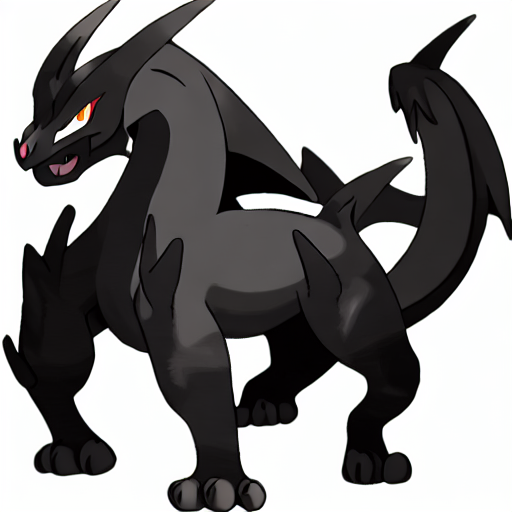


Image 1 Caption: a black pokemon pokemon with red eyes and a black tail


Similarity between the sentences: 0.6424160003662109


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dragon with fire

Image 1:


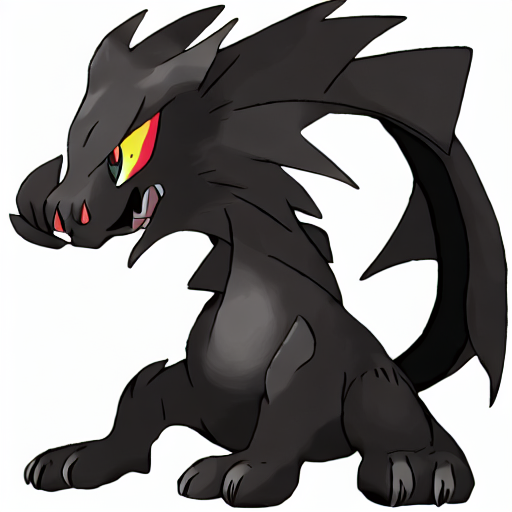


Image 1 Caption: a black and yellow pokemon pokemon


Similarity between the sentences: 0.47852635383605957


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dragon with fire

Image 1:


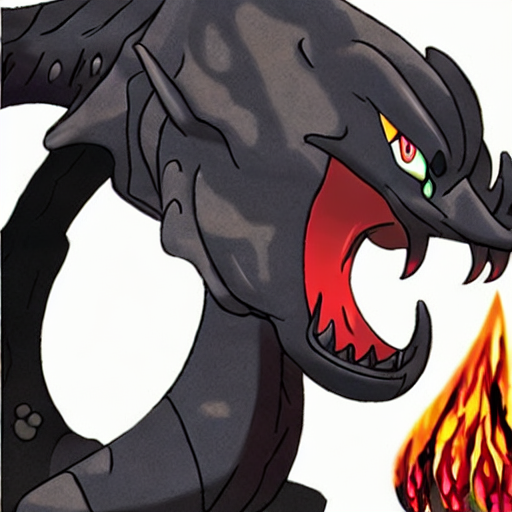


Image 1 Caption: a cartoon character with a fire in his mouth


Similarity between the sentences: 0.6163840889930725


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dragon with fire

Image 1:


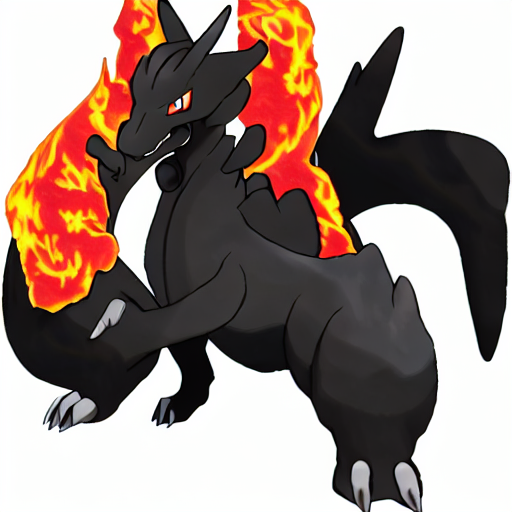


Image 1 Caption: a black pokemon with flames on its back


Similarity between the sentences: 0.6726372838020325


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dragon with fire

Image 1:


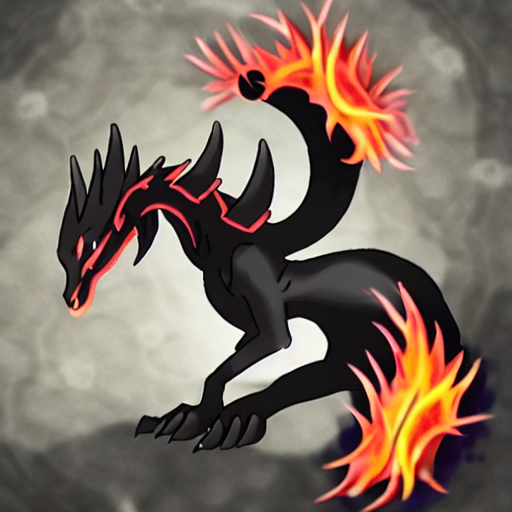


Image 1 Caption: a black and red fire dragon with flames around it


Similarity between the sentences: 0.8902052640914917
0.6600337982177734


In [15]:
num_runs = 5

results = []
for i in range(num_runs):
    result = run_pipeline('a black dragon with fire', google_news_word_embedding)
    results.append(result)

mean_result = sum(results) / len(results)

print(mean_result)

The results for those 5 attempts seem to be quite different, depending on the generated image. But the average is not to high, while it's certainly not bad.
An iteresting note: BLIP seems to recognize Pokemons most of the time. So let's try to add this to the caption: 

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a bird pokemon with wings and green eyes

Image 1:


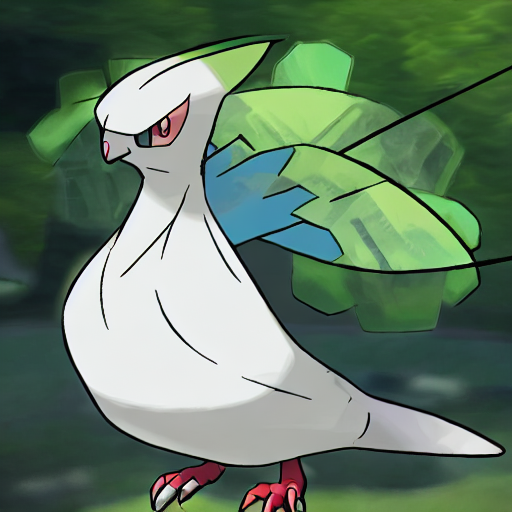


Image 1 Caption: a white bird with a green leaf on its back


Similarity between the sentences: 0.6724513173103333


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a bird pokemon with wings and green eyes

Image 1:


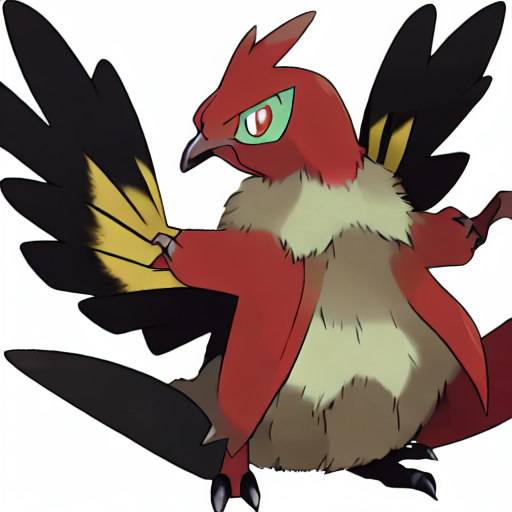


Image 1 Caption: a red and black bird with yellow wings


Similarity between the sentences: 0.7428944706916809


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a bird pokemon with wings and green eyes

Image 1:


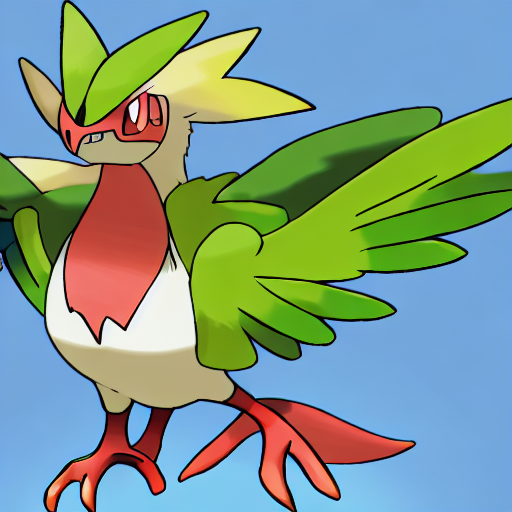


Image 1 Caption: a cartoon bird with green and red feathers


Similarity between the sentences: 0.729848325252533


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a bird pokemon with wings and green eyes

Image 1:


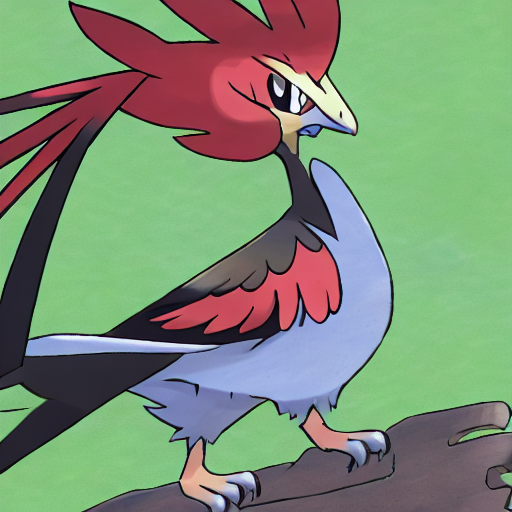


Image 1 Caption: a bird with a red head and black wings


Similarity between the sentences: 0.7665948271751404


  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a bird pokemon with wings and green eyes

Image 1:


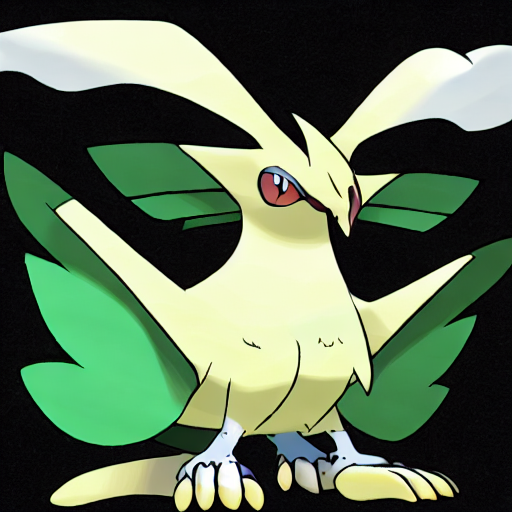


Image 1 Caption: a yellow pokemon pokemon with a green leaf


Similarity between the sentences: 0.7514591813087463
Mean image similarity: 0.7326496243476868


In [41]:
num_runs = 5

results = []
for i in range(num_runs):
    result = run_pipeline('a bird pokemon with wings and green eyes', google_news_word_embedding)
    results.append(result)

mean_result = sum(results) / len(results)

print(f'Mean image similarity: {mean_result}')

This helps the general similarity, however, BLIP seems to be quite random, which exact body parts it's describing. Sometimes, it's just the wings or the beak for example.

Let's do a final test with a bigger number of images, but without the ouput this time.


In [43]:
num_runs = 50

results = []
for i in range(num_runs):
    result = run_pipeline_no_print('a white dragon pokemon with red eyes', google_news_word_embedding)
    results.append(result)

mean_result = sum(results) / len(results)

print(f'Mean image similarity: {mean_result}')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Mean image similarity: 0.8131811022758484


Also with bigger image sample sizes the results seems to be consitant.

# Conclusions

At this point I burned through 80 of my 100 included compute units of Colab Pro and this project gets a little bit to big. So I think it's a good point to come to a conclusion. 

The 2 main take aways are:

* The most valuable option to increase the similarity between the captions is to give detailled prompts that are tailored for the models. So prompt engineering is a very important tool for generative models.
* The finetuning can help for certain use cases, however it would probably perform even better if you finetune all the associated models.

Those two take aways are nothing very unexpected, but it's still nice to have it confirmed and I could learn a lot of things during this project. Of course there is still room for improvements and other things, some further points and ideas are listed below.


#### Further possible improvements:

* **Most important**: Finetune the BLIP model, also with Pokemon data.
* If StableDiffusion detects potential NSFW content it just returns a black image. This happens quite frequently (as you can see in the output of the bigger image sample size runs). Those appearing can drag down the results by quite a lot, depending on how often this appears. So it could be a good idea to filter those out by building a function that for example filters out similarities below 0.1. or similar approaches.
* Use a different word embedding. Ideally there would be a matching word embedding. For example [Poke2Vec](https://www.smogon.com/forums/threads/poke2vec-vector-embeddings-of-pokemon.3665786/). Important to note is that our finetuning does not use the names of Pokemons.
* Use all the methods with a different approach, maybe you could generate comics, retro art or similar cool things!



And now: thanks for reading!

Sincerely,

Nick


